# Zonal Averaging

This section demonstrates how to perform Zonal Averaging using UXarray, covering both non-conservative and conservative methods.


## Notebook Roadmap

- [1. Zonal Mean Basics](#1-zonal-mean-basics) — terminology and the two averaging flavors available in UXarray.
- [2. Non-Conservative Zonal Averaging](#2-non-conservative-zonal-averaging) — default sampling, plotting, and tuning latitude spacing.
- [3. Conservative Zonal Averaging](#3-conservative-zonal-averaging) — area-weighted bands, conservation checks, and comparisons.
- [4. Combined Plots](#4-combined-plots) — pair global maps with their zonal means for context.
- [5. HEALPix Zonal Averaging (Conservative vs Non-Conservative)](#5-healpix-zonal-averaging-conservative-vs-non-conservative) — run the same workflow on a different grid.
- [6. 2D Zonal Means on NE30 (RELHUM)](#6-2d-zonal-means-on-ne30-relhum) — build latitude–height slices and inspect the differences.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import uxarray as ux

uxds = ux.open_dataset(
    "../../test/meshfiles/ugrid/outCSne30/outCSne30.ug",
    "../../test/meshfiles/ugrid/outCSne30/outCSne30_vortex.nc",
)

## 1. Zonal Mean Basics

### Step 1.1: Understand the two averaging flavors

A zonal average (or zonal mean) is a statistical measure that represents the average of a variable along lines of constant latitude or over latitudinal bands.

UXarray provides two types of zonal averaging:
- **Non-conservative**: Samples values at specific latitude lines
- **Conservative**: Preserves integral quantities by weighting faces by their area overlap with latitude bands

```{seealso}
[NCL Zonal Average](https://www.ncl.ucar.edu/Applications/zonal.shtml)
```


## 2. Non-Conservative Zonal Averaging

The non-conservative method samples values at specific lines of constant latitude. This is the default behavior and is suitable for visualization and general analysis where exact conservation is not required.

### Step 2.1: Visualize the global field and latitude bands

Let's first visualize our data field and then demonstrate zonal averaging:


In [2]:
# Display the global field
uxds["psi"].plot(cmap="inferno", periodic_elements="split", title="Global Field")

# Show conceptual latitude bands for zonal averaging
print("Latitude bands for zonal averaging:")
lat_bands = np.arange(-90, 91, 30)
for i, lat in enumerate(lat_bands[:-1]):
    print(f"Band {i + 1}: {lat}° to {lat_bands[i + 1]}°")

Latitude bands for zonal averaging:
Band 1: -90° to -60°
Band 2: -60° to -30°
Band 3: -30° to 0°
Band 4: 0° to 30°
Band 5: 30° to 60°
Band 6: 60° to 90°


### Step 2.2: Compute the default zonal mean

Calling `.zonal_mean()` with no arguments samples every 10° between -90° and 90° and returns one value per latitude line.


In [3]:
zonal_mean_psi = uxds["psi"].zonal_mean()
zonal_mean_psi

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/491649382.py:1: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  zonal_mean_psi = uxds["psi"].zonal_mean()


<xarray.DataArray 'psi_zonal_mean' (latitudes: 19)> Size: 152B
array([1.08546247, 1.09219987, 1.10863654, 1.10011333, 1.04989243,
       1.03074397, 1.01980815, 1.01312147, 0.9973705 , 1.00000001,
       1.00262952, 0.98687854, 0.98019186, 0.96925608, 0.95010754,
       0.89988665, 0.89136345, 0.90780013, 0.91453753])
Coordinates:
  * latitudes  (latitudes) int64 152B -90 -80 -70 -60 -50 -40 ... 50 60 70 80 90
Attributes:
    zonal_mean:    True
    conservative:  False

### Step 2.3: Inspect the default sampling

The default latitude range is between -90 and 90 degrees with a step size of 10 degrees. The plot below shows the resulting profile so you can see how many points are sampled across the globe.


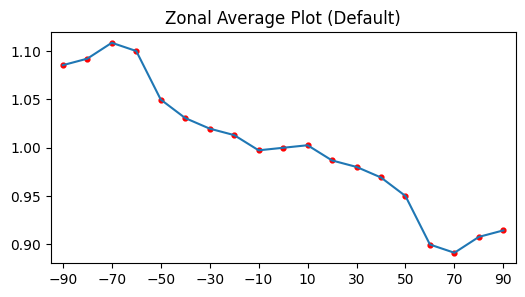

In [4]:
lats = zonal_mean_psi["latitudes"].values
vals = zonal_mean_psi.values
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lats, vals, "-")
ax.scatter(lats, vals, s=12, color="red")
ax.set_title("Zonal Average Plot (Default)")
ax.set_xlim(-95, 95)
ax.set_xticks(np.arange(-90, 100, 20))

### Step 2.4: Customize the `lat` parameter

The range of latitudes can be modified by using the `lat` parameter. It accepts:

* **Single scalar**: e.g., `lat=45`
* **List/array**: e.g., `lat=[10, 20]` or `lat=np.array([10, 20])`
* **Tuple**: e.g., `(min_lat, max_lat, step)`


In [5]:
zonal_mean_psi_large = uxds["psi"].zonal_mean(lat=(-90, 90, 1))

/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/322622288.py:1: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  zonal_mean_psi_large = uxds["psi"].zonal_mean(lat=(-90, 90, 1))


### Step 2.5: Visualize the higher-resolution sampling

A 1° step resolves more structure, so the plot below uses the denser coordinate returned from the customized call.


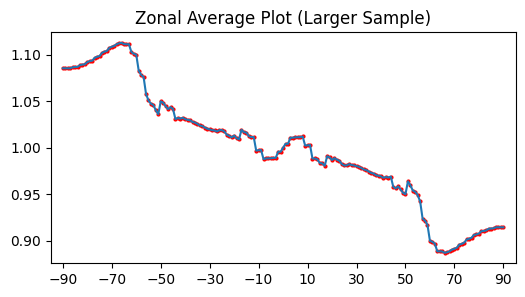

In [6]:
lats = zonal_mean_psi_large["latitudes"].values
vals = zonal_mean_psi_large.values
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lats, vals, "-")
ax.scatter(lats, vals, s=4, color="red")
ax.set_title("Zonal Average Plot (Larger Sample)")
ax.set_xlim(-95, 95)
ax.set_xticks(np.arange(-90, 100, 20))

## 3. Conservative Zonal Averaging

Conservative zonal averaging preserves integral quantities (mass, energy, momentum) by computing area-weighted averages over latitude bands. This is essential for climate model analysis, energy budget calculations, and any application requiring physical conservation.

Key differences from non-conservative sampling:
- **Non-conservative**: Samples at specific latitude lines
- **Conservative**: Averages over latitude bands between adjacent lines
- **Conservation**: Preserves global integrals to machine precision

### Step 3.1: Configure latitude bands and compute the zonal mean

We pass latitude band edges to `.zonal_mean(..., conservative=True)` so each band carries the correct area weight.


In [7]:
# Conservative zonal averaging with bands
bands = np.array([-90, -60, -30, 0, 30, 60, 90])
conservative_result = uxds["psi"].zonal_mean(lat=bands, conservative=True)
conservative_result

/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/2677525412.py:3: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  conservative_result = uxds["psi"].zonal_mean(lat=bands, conservative=True)


<xarray.DataArray 'psi_zonal_mean' (latitudes: 6)> Size: 48B
array([1.10364701, 1.03868616, 1.00588496, 0.99347061, 0.96125331,
       0.89634629])
Coordinates:
  * latitudes  (latitudes) float64 48B -75.0 -45.0 -15.0 15.0 45.0 75.0
Attributes:
    zonal_mean:      True
    conservative:    True
    lat_band_edges:  [-90. -60. -30.   0.  30.  60.  90.]

### Step 3.2: Verify conservation

A key advantage of conservative zonal averaging is that it preserves global integrals.


In [8]:
# Test conservation property
global_mean = uxds["psi"].mean()
full_sphere_conservative = uxds["psi"].zonal_mean(lat=[-90, 90], conservative=True)
conservation_error = abs(global_mean.values - full_sphere_conservative.values[0])

print(f"Global mean: {global_mean.values:.12f}")
print(f"Conservative full sphere: {full_sphere_conservative.values[0]:.12f}")
print(f"Conservation error: {conservation_error:.2e}")

Global mean: 1.000000001533
Conservative full sphere: 1.000000001829
Conservation error: 2.96e-10


/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/1814533177.py:3: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  full_sphere_conservative = uxds["psi"].zonal_mean(lat=[-90, 90], conservative=True)


### Step 3.3: Understand the `lat` parameter signature

Both conservative and non-conservative modes can use the same `lat` parameter, but they interpret it differently:

- **Non-conservative**: Creates sample points at the specified latitudes
- **Conservative**: Uses the latitudes as band edges, creating bands between adjacent points


In [9]:
# Demonstrate signature behavior
lat_tuple = (-90, 90, 30)  # Every 30 degrees

# Non-conservative: samples at lines
non_cons_lines = uxds["psi"].zonal_mean(lat=lat_tuple)
print(f"Non-conservative with lat={lat_tuple}:")
print(f"Sample points: {non_cons_lines.coords['latitudes'].values}")
print(f"Count: {len(non_cons_lines.coords['latitudes'].values)} points")

# Conservative: creates bands between lines
cons_bands = uxds["psi"].zonal_mean(lat=lat_tuple, conservative=True)
print(f"\nConservative with lat={lat_tuple}:")
print(f"Band centers: {cons_bands.coords['latitudes'].values}")
print(f"Count: {len(cons_bands.coords['latitudes'].values)} bands")

Non-conservative with lat=(-90, 90, 30):
Sample points: [-90 -60 -30   0  30  60  90]
Count: 7 points

Conservative with lat=(-90, 90, 30):
Band centers: [-75. -45. -15.  15.  45.  75.]
Count: 6 bands


/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/162242150.py:5: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  non_cons_lines = uxds["psi"].zonal_mean(lat=lat_tuple)
/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/162242150.py:11: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  cons_bands = uxds["psi"].zonal_mean(lat=lat_tuple, conservative=True)


### Step 3.4: Visual comparison (lines vs bands)

The differences between methods reflect their fundamental approaches:

- **Conservative**: More accurate for physical quantities because it accounts for the actual area of each face within latitude bands
- **Non-conservative**: Faster but approximates by sampling at specific latitude lines

The differences you see indicate how much area-weighting matters for your specific data and grid resolution.


/var/folders/_f/dc3kjt3n3ms9ntb5fcj5mplm0000gq/T/ipykernel_18893/523619492.py:3: DeprecationWarning: zonal_mean returns an xarray.DataArray (no grid topology). Returning UxDataArray is deprecated and will be removed.
  non_conservative_comparison = uxds["psi"].zonal_mean(lat=band_centers)


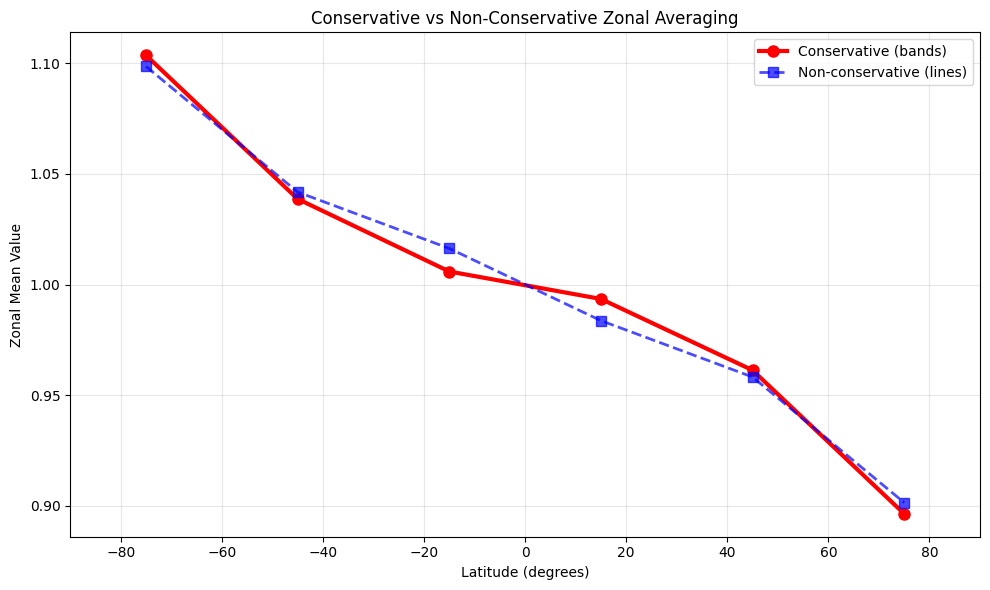

In [10]:
# Compare with non-conservative at same latitudes
band_centers = 0.5 * (bands[:-1] + bands[1:])
non_conservative_comparison = uxds["psi"].zonal_mean(lat=band_centers)

# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(
    conservative_result.coords["latitudes"],
    conservative_result.values,
    "o-",
    label="Conservative (bands)",
    linewidth=3,
    markersize=8,
    color="red",
)
ax.plot(
    non_conservative_comparison.coords["latitudes"],
    non_conservative_comparison.values,
    "s--",
    label="Non-conservative (lines)",
    linewidth=2,
    markersize=7,
    color="blue",
    alpha=0.7,
)

ax.set_xlabel("Latitude (degrees)")
ax.set_ylabel("Zonal Mean Value")
ax.set_title("Conservative vs Non-Conservative Zonal Averaging")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(-90, 90)

plt.tight_layout()
plt.show()

### Step 3.5: Quantify the differences

The differences between conservative and non-conservative results depend on several factors:

1. **Grid Resolution**: Higher resolution grids show smaller differences
2. **Data Variability**: Rapidly changing fields show larger differences
3. **Latitude Band Size**: Wider bands increase the importance of area-weighting

**Which is more accurate?**
- **Conservative**: More accurate for physical quantities (mass, energy, momentum) because it preserves integral properties
- **Non-conservative**: Adequate for visualization and qualitative analysis

**When differences matter most:**
- Variable resolution grids (where face sizes vary significantly)
- Physical conservation requirements
- Quantitative analysis and budget calculations


In [11]:
# Quantify the differences
differences = conservative_result.values - non_conservative_comparison.values
max_diff = np.max(np.abs(differences))
mean_diff = np.mean(np.abs(differences))

print(f"Maximum absolute difference: {max_diff:.6f}")
print(f"Mean absolute difference: {mean_diff:.6f}")
print(
    f"Relative difference (max): {max_diff / np.mean(np.abs(conservative_result.values)) * 100:.3f}%"
)

Maximum absolute difference: 0.010437
Mean absolute difference: 0.006088
Relative difference (max): 1.044%


## 4. Combined Plots

### Step 4.1: Pair a global map with its zonal mean

It is often desired to plot the zonal average alongside other plots, such as color or contour plots, so you can see both the spatial distribution and its latitude summary in one glance.


Global Field:


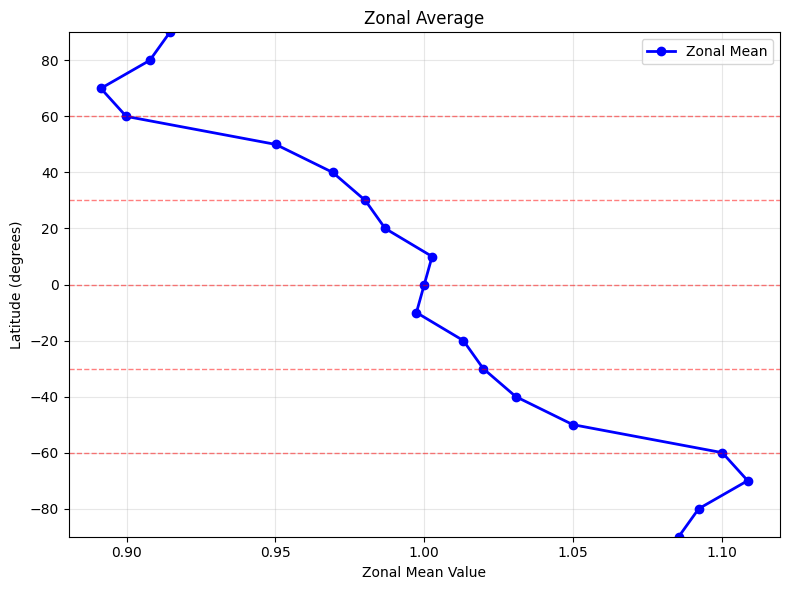

In [12]:
# Display the global field
print("Global Field:")
uxds["psi"].plot(cmap="inferno", periodic_elements="split", title="Global Field")

# Create zonal average plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    zonal_mean_psi.values,
    zonal_mean_psi.coords["latitudes"],
    "o-",
    linewidth=2,
    markersize=6,
    color="blue",
    label="Zonal Mean",
)

ax.set_xlabel("Zonal Mean Value")
ax.set_ylabel("Latitude (degrees)")
ax.set_title("Zonal Average")
ax.grid(True, alpha=0.3)
ax.set_ylim(-90, 90)
ax.legend()

# Add reference latitude lines
sample_bands = [-60, -30, 0, 30, 60]
for lat_band in sample_bands:
    ax.axhline(y=lat_band, color="red", linestyle="--", alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

## 5. HEALPix Zonal Averaging (Conservative vs Non-Conservative)

### Step 5.1: Compare conservative and non-conservative averages on HEALPix

This example demonstrates the key differences between conservative (area-weighted) and non-conservative (point-sampling) zonal averaging on a HEALPix grid.


In [ ]:
# HEALPix Zonal Averaging: Conservative vs Non-Conservative Methods
# This example demonstrates the key differences between conservative (area-weighted)
# and non-conservative (point-sampling) zonal averaging on a HEALPix grid.

import numpy as np

import uxarray as ux

# Create HEALPix grid with synthetic data
# Using sin(latitude) as test function - varies smoothly with latitude
uxgrid = ux.Grid.from_healpix(zoom=3, pixels_only=False)
data = np.sin(np.deg2rad(uxgrid.face_lat.values))
uxda = ux.UxDataArray(data, uxgrid=uxgrid, dims=["n_face"], name="val")

# Define analysis region: 20° latitude band centered at 42°N
band_edges = np.array([32.0, 52.0])  # Southern USA to Canada
lat_center = 42.0  # Approximate latitude of Chicago/Boston

# Method 1: Conservative zonal mean (area-weighted average over band)
# - Integrates data over entire latitude band
# - Accounts for spherical geometry (smaller areas near poles)
# - Preserves physical quantities like total energy/mass
z_cons = uxda.zonal_mean(lat=band_edges, conservative=True)

# Method 2: Non-conservative zonal mean (point sampling at specific latitude)
# - Samples data at exact latitude circle
# - Faster computation, simpler interpretation
# - Better for comparison with station observations
z_noncons = uxda.zonal_mean(lat=lat_center)

# Calculate theoretical values for validation
theoretical_point = np.sin(np.deg2rad(lat_center))  # Exact at 42°N
# For band average: integrate sin(lat)*cos(lat) / integrate cos(lat)
lat_s, lat_n = np.deg2rad(band_edges)
theoretical_band = (
    0.5 * (np.sin(lat_n) ** 2 - np.sin(lat_s) ** 2) / (np.sin(lat_n) - np.sin(lat_s))
)

# Display results
print("=" * 65)
print("ZONAL AVERAGING ON HEALPix GRID: Conservative vs Non-Conservative")
print("=" * 65)
print("\nTest function: sin(latitude)")
print(f"Analysis band: {band_edges[0]:.0f}°N to {band_edges[1]:.0f}°N")
print(f"Center latitude: {lat_center:.0f}°N")
print("Grid resolution: HEALPix zoom level 3 (~1.8° spacing)")

print("\n" + "-" * 65)
print("RESULTS:")
print("-" * 65)
print(f"Conservative (band average):     {float(z_cons.values[0]):.4f}")
print(f"  → Theoretical value:            {theoretical_band:.4f}")
print("  → Physical meaning: Area-weighted average over 20° band")
print("  → Use case: Flux calculations, energy budgets\n")

print(f"Non-conservative (point value):  {float(z_noncons.values[0]):.4f}")
print(f"  → Theoretical value:            {theoretical_point:.4f}")
print(f"  → Physical meaning: Value at exactly {lat_center}°N")
print("  → Use case: Station comparisons, spot measurements")

print("\n" + "-" * 65)
print("KEY INSIGHTS:")
print("-" * 65)
difference = float(z_noncons.values[0]) - float(z_cons.values[0])
print(
    f"• Difference between methods: {difference:.4f} ({difference / float(z_noncons.values[0]) * 100:.1f}%)"
)
print("• Conservative < Non-conservative because sin(lat) increases toward")
print("  the pole, and southern portion of band has lower values")
print("• Both methods are 'correct' - choose based on your application:")
print("  - Conservative: preserves integrated quantities")
print("  - Non-conservative: provides local values")

## 6. 2D Zonal Means on NE30 (RELHUM)

Everything above uses a single-level field. The CAM-SE NE30 grid ships with a multi-level relative humidity field, so we can see how zonal averaging builds a latitude–height cross section. Each step below walks through the process with extra explanations for first-time users.


### Step 6.1: Load the NE30 grid and prepare the field

We point UXarray to the grid and data files under `test/meshfiles/scrip/ne30pg2/`, open the `RELHUM` variable, and drop the leading time dimension so the array is only `(level, face)`.

In [ ]:
from pathlib import Path

import xarray as xr

grid_path = Path("../../test/meshfiles/scrip/ne30pg2/grid.nc")
data_path = Path("../../test/meshfiles/scrip/ne30pg2/data.nc")

ne30_ds = ux.open_dataset(grid_path, data_path)
relhum = ne30_ds["RELHUM"]

for dim in ("time", "t", "step"):
    if dim in relhum.dims:
        relhum = relhum.isel({dim: 0})

level_dim = "level" if "level" in relhum.dims else relhum.dims[0]
levels = relhum.coords.get(
    level_dim,
    xr.DataArray(np.arange(relhum.sizes[level_dim]), dims=level_dim),
).values

relhum

### Step 6.2: Build latitude samples and compute both zonal means

Sampling every 10 degrees gives us clearly separated latitude bands while staying light on compute. The non-conservative average uses those values as **centers**, while the conservative option treats them as **band edges** so that each band carries the correct area weight. Adjust the spacing if you need higher detail or faster turnaround.

In [ ]:
lat_edges_deg = np.arange(-90.0, 90.0 + 10.0, 10.0)
lat_centers_deg = 0.5 * (lat_edges_deg[:-1] + lat_edges_deg[1:])


def stack_zonal_means(data_array, lat_values, *, conservative):
    slices = []
    for lev in range(data_array.sizes[level_dim]):
        zonal_slice = data_array.isel({level_dim: lev}).zonal_mean(
            lat=lat_values, conservative=conservative
        )
        slices.append(zonal_slice)
    zonal = xr.concat(slices, dim=level_dim)
    return zonal.assign_coords({level_dim: levels}).rename({"latitudes": "lat"})


zonal_nc = stack_zonal_means(relhum, lat_centers_deg, conservative=False)
zonal_c = stack_zonal_means(relhum, lat_edges_deg, conservative=True)
zonal_diff = zonal_c - zonal_nc

zonal_nc

### Step 6.3: Visualize the latitude–level slices

Placing the two 2D sections next to each other shows the smoothing introduced by area weighting, while a third panel plotting the signed difference (conservative − non-conservative) highlights where the methods diverge. Because every panel uses the same color scale (and the difference plot uses a diverging palette), the contrast is easy to spot.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)

value_min = float(min(zonal_nc.min().values, zonal_c.min().values))
value_max = float(max(zonal_nc.max().values, zonal_c.max().values))

mesh_nc = axes[0].pcolormesh(
    zonal_nc["lat"],
    levels,
    zonal_nc.transpose(level_dim, "lat"),
    shading="nearest",
    cmap="viridis",
    vmin=value_min,
    vmax=value_max,
)
axes[0].set_title("Non-conservative (centers)")
axes[0].set_xlabel("Latitude (deg)")
axes[0].set_ylabel(level_dim)
axes[0].set_xlim(-90, 90)

mesh_c = axes[1].pcolormesh(
    zonal_c["lat"],
    levels,
    zonal_c.transpose(level_dim, "lat"),
    shading="nearest",
    cmap="viridis",
    vmin=value_min,
    vmax=value_max,
)
axes[1].set_title("Conservative (bands)")
axes[1].set_xlabel("Latitude (deg)")
axes[1].set_xlim(-90, 90)

diff_max = float(np.nanmax(np.abs(zonal_diff.values)))
if diff_max == 0:
    diff_max = 1e-6
mesh_diff = axes[2].pcolormesh(
    zonal_diff["lat"],
    levels,
    zonal_diff.transpose(level_dim, "lat"),
    shading="nearest",
    cmap="RdBu_r",
    vmin=-diff_max,
    vmax=diff_max,
)
axes[2].set_title("Difference (conservative - non)")
axes[2].set_xlabel("Latitude (deg)")
axes[2].set_xlim(-90, 90)

cbar_field = fig.colorbar(
    mesh_nc, ax=[axes[0], axes[1]], orientation="vertical", fraction=0.04, pad=0.02
)
cbar_field.set_label("RELHUM zonal mean")

cbar_diff = fig.colorbar(
    mesh_diff, ax=[axes[2]], orientation="vertical", fraction=0.08, pad=0.02
)
cbar_diff.set_label("RELHUM difference")

### Step 6.4: Spot-check the difference numerically

Visuals are helpful, but printing quick summary statistics and a few sample latitude bands makes it clear how large the conservative correction is.

In [ ]:
abs_diff = np.abs(zonal_diff)
max_abs = float(abs_diff.max())
mean_abs = float(abs_diff.mean())
per_level_max = abs_diff.max(dim="lat")

print(f"Max absolute difference: {max_abs:.3f}")
print(f"Mean absolute difference: {mean_abs:.3f}")

preview_levels = per_level_max.isel({level_dim: slice(0, 5)})
preview_levels